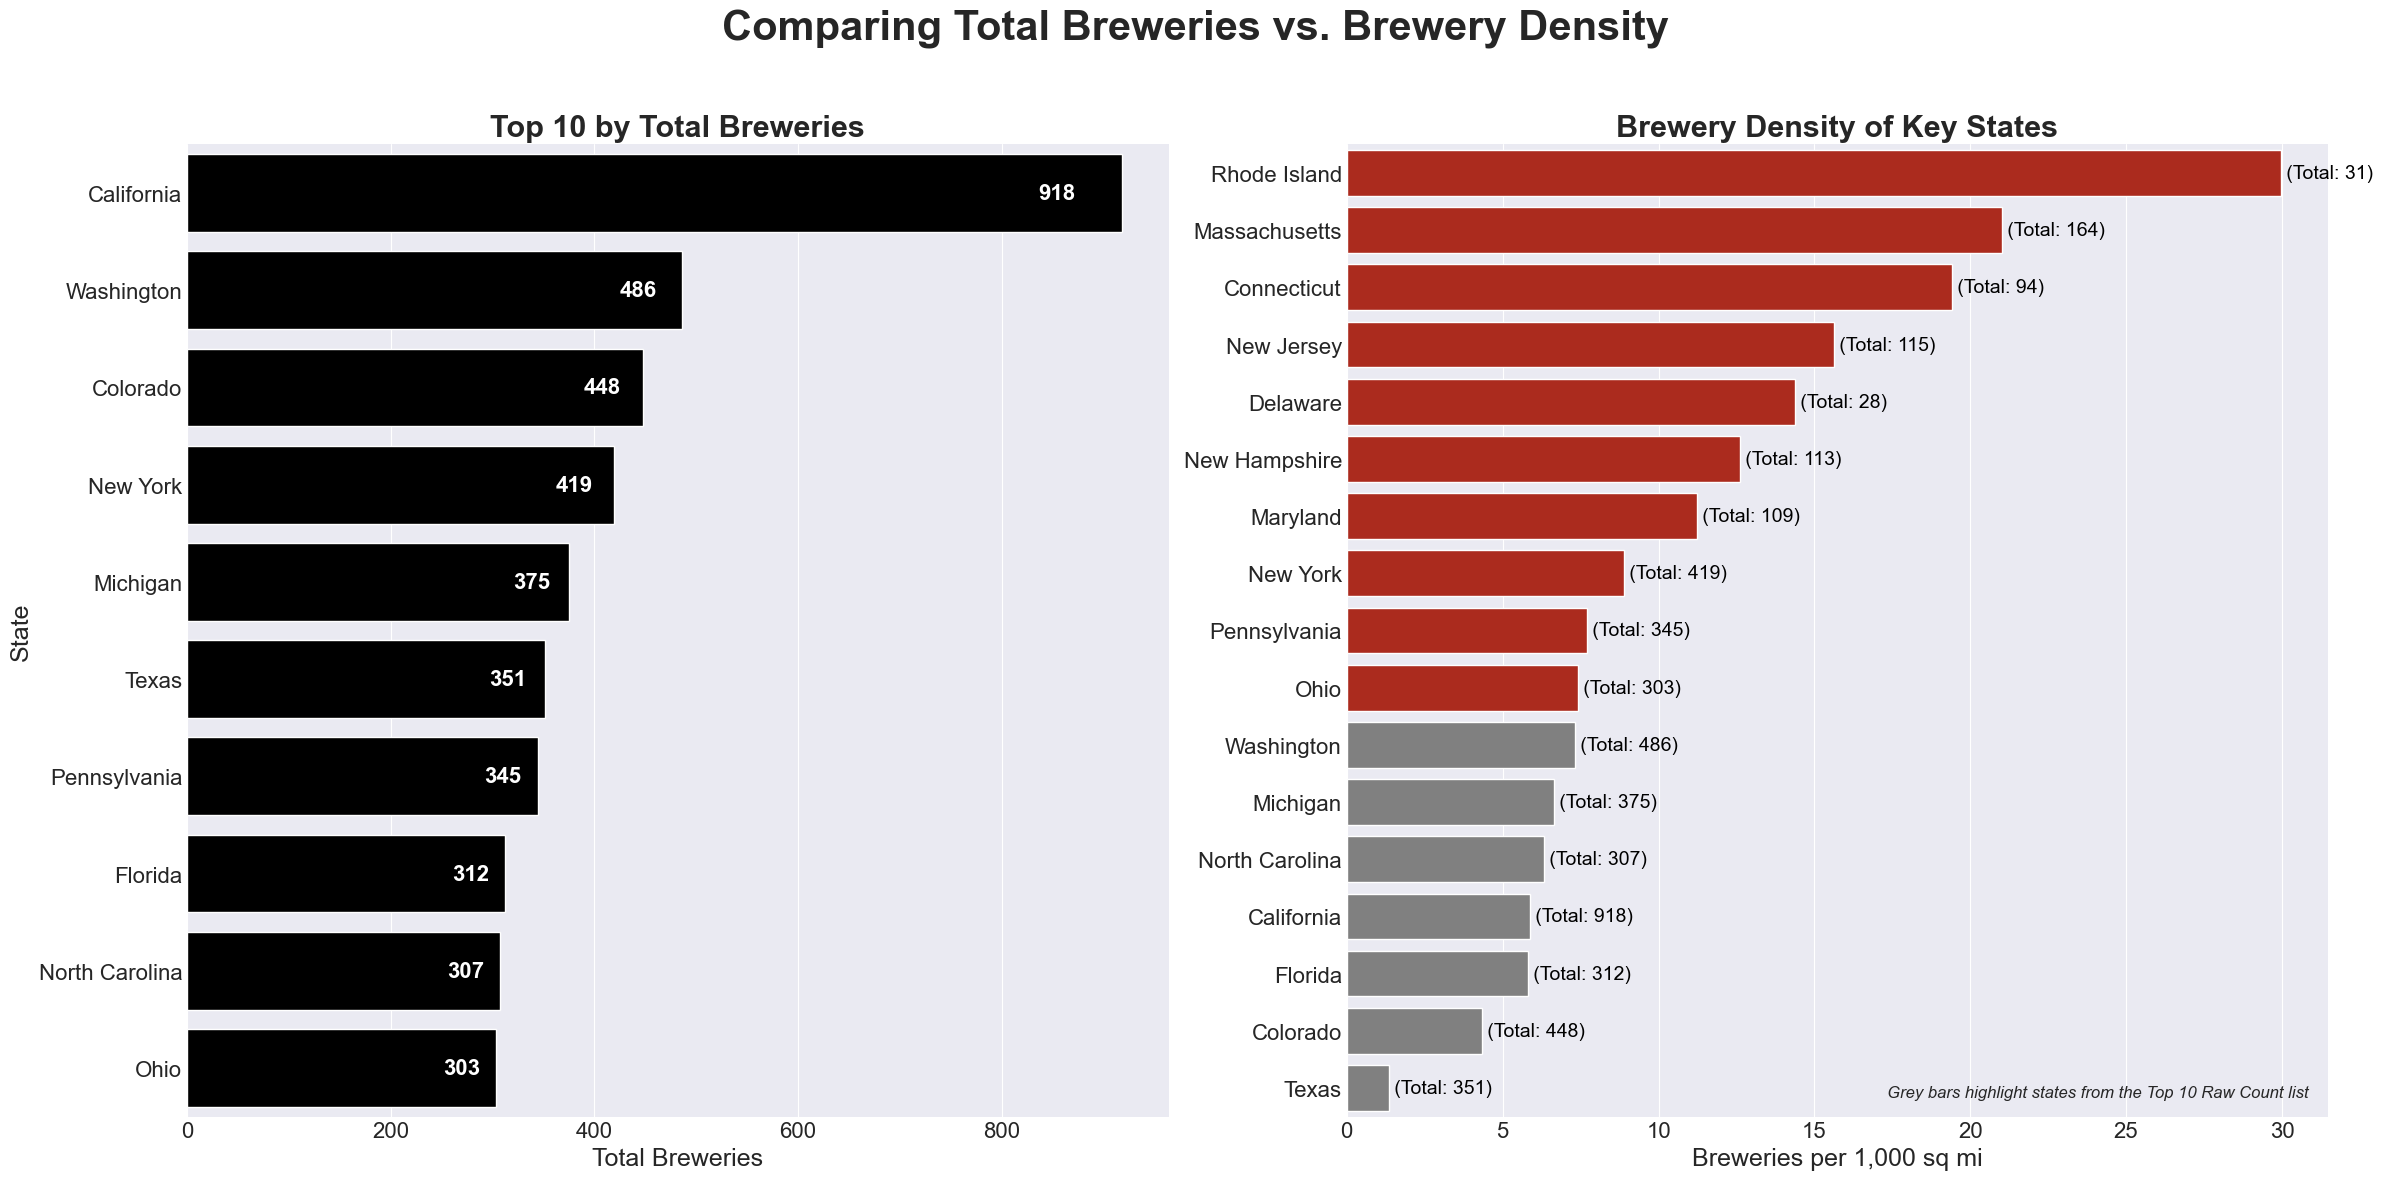

In [11]:
#2nd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data ---
try:
    df = pd.read_csv("done_cleaning.csv")
    us_df = df[df['country'] == 'United States'].copy()
except FileNotFoundError:
    print(" Error: 'done_cleaning.csv' not found.")
    exit()

# --- 2. Data Enrichment & Analysis ---
state_areas = {
    'Alabama': 50645, 'Alaska': 570641, 'Arizona': 113594, 'Arkansas': 52035, 'California': 155779,
    'Colorado': 103642, 'Connecticut': 4842, 'Delaware': 1949, 'Florida': 53625, 'Georgia': 57513,
    'Hawaii': 6423, 'Idaho': 82643, 'Illinois': 55519, 'Indiana': 35826, 'Iowa': 55857,
    'Kansas': 81759, 'Kentucky': 39486, 'Louisiana': 43204, 'Maine': 30843, 'Maryland': 9707,
    'Massachusetts': 7800, 'Michigan': 56539, 'Minnesota': 79627, 'Mississippi': 46923,
    'Missouri': 68742, 'Montana': 145546, 'Nebraska': 76824, 'Nevada': 109781, 'New Hampshire': 8953,
    'New Jersey': 7354, 'New Mexico': 121298, 'New York': 47126, 'North Carolina': 48618,
    'North Dakota': 69001, 'Ohio': 40861, 'Oklahoma': 68595, 'Oregon': 95988, 'Pennsylvania': 44743,
    'Rhode Island': 1034, 'South Carolina': 30061, 'South Dakota': 75811, 'Tennessee': 41235,
    'Texas': 261232, 'Utah': 82170, 'Vermont': 9217, 'Virginia': 39490, 'Washington': 66456,
    'West Virginia': 24038, 'Wisconsin': 54158, 'Wyoming': 97093
}
state_counts = us_df['state'].value_counts().reset_index()
state_counts.columns = ['State', 'Brewery Count']
area_df = pd.DataFrame(list(state_areas.items()), columns=['State', 'Land Area (sq mi)'])
density_df = pd.merge(state_counts, area_df, on='State')
density_df['Breweries per 1k sq mi'] = (density_df['Brewery Count'] / density_df['Land Area (sq mi)']) * 1000

# Get the Top 10 lists
top_10_by_count = density_df.sort_values(by='Brewery Count', ascending=False).head(10)
top_10_by_density = density_df.sort_values(by='Breweries per 1k sq mi', ascending=False).head(10)

# Create a combined list of states for the density plot
count_states = top_10_by_count['State'].tolist()
density_states = top_10_by_density['State'].tolist()
combined_states = list(set(count_states + density_states))
density_plot_df = density_df[density_df['State'].isin(combined_states)].sort_values(by='Breweries per 1k sq mi', ascending=False)

# --- FIX 1: Create a palette DICTIONARY for hue mapping ---
highlight_color = 'grey'
main_color = '#C21807' # Red
color_list = [highlight_color if (state in count_states and state not in density_states) else main_color for state in density_plot_df['State']]
palette_dict = dict(zip(density_plot_df['State'], color_list))


# --- 3. Visualization ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
fig.suptitle('Comparing Total Breweries vs. Brewery Density', fontsize=30, weight='bold')

# Plot 1: Top 10 by Raw Count (Unchanged)
sns.barplot(x='Brewery Count', y='State', data=top_10_by_count, color='black', ax=ax1)
ax1.set_title('Top 10 by Total Breweries', fontsize=22, weight='bold')
ax1.set_xlabel('Total Breweries', fontsize=18)
ax1.set_ylabel('State', fontsize=18)

# --- FIX 2: Update barplot call to use `hue` and `legend=False` ---
sns.barplot(
    x='Breweries per 1k sq mi',
    y='State',
    data=density_plot_df,
    palette=palette_dict,
    ax=ax2,
    hue='State', # Assign State to hue
    legend=False # Disable the legend
)
ax2.set_title('Brewery Density of Key States', fontsize=22, weight='bold')
ax2.set_xlabel('Breweries per 1,000 sq mi', fontsize=18)
ax2.set_ylabel('')
ax2.text(0.98, 0.02, 'Grey bars highlight states from the Top 10 Raw Count list', transform=ax2.transAxes, ha='right', fontsize=12, style='italic')


# --- 4. Annotations & Formatting ---
# Annotate the first chart
for p in ax1.patches:
    ax1.text(p.get_width() * 0.95, p.get_y() + p.get_height() / 2., f'{int(p.get_width())}', ha='right', va='center', fontsize=16, color='white', weight='bold')

# --- FIX 3: Correct the annotation loop for the second chart ---
# We iterate through the y-tick labels to correctly identify the state for each bar
for i, bar in enumerate(ax2.patches):
    state_name = density_plot_df['State'].iloc[i]
    count = density_plot_df['Brewery Count'].iloc[i]
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2., f' (Total: {count})', ha='left', va='center', fontsize=14, color='black')

for ax in [ax1, ax2]:
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('brewery_density_comparison.png')
plt.show()

The analysis clearly shows that the states with the most breweries are not necessarily the states with the strongest craft beer culture. While large states like California and Washington lead in sheer numbers due to their size, the density chart reveals that smaller states like Rhode island Massachusetts lead ,while california lies at 14 and 11.

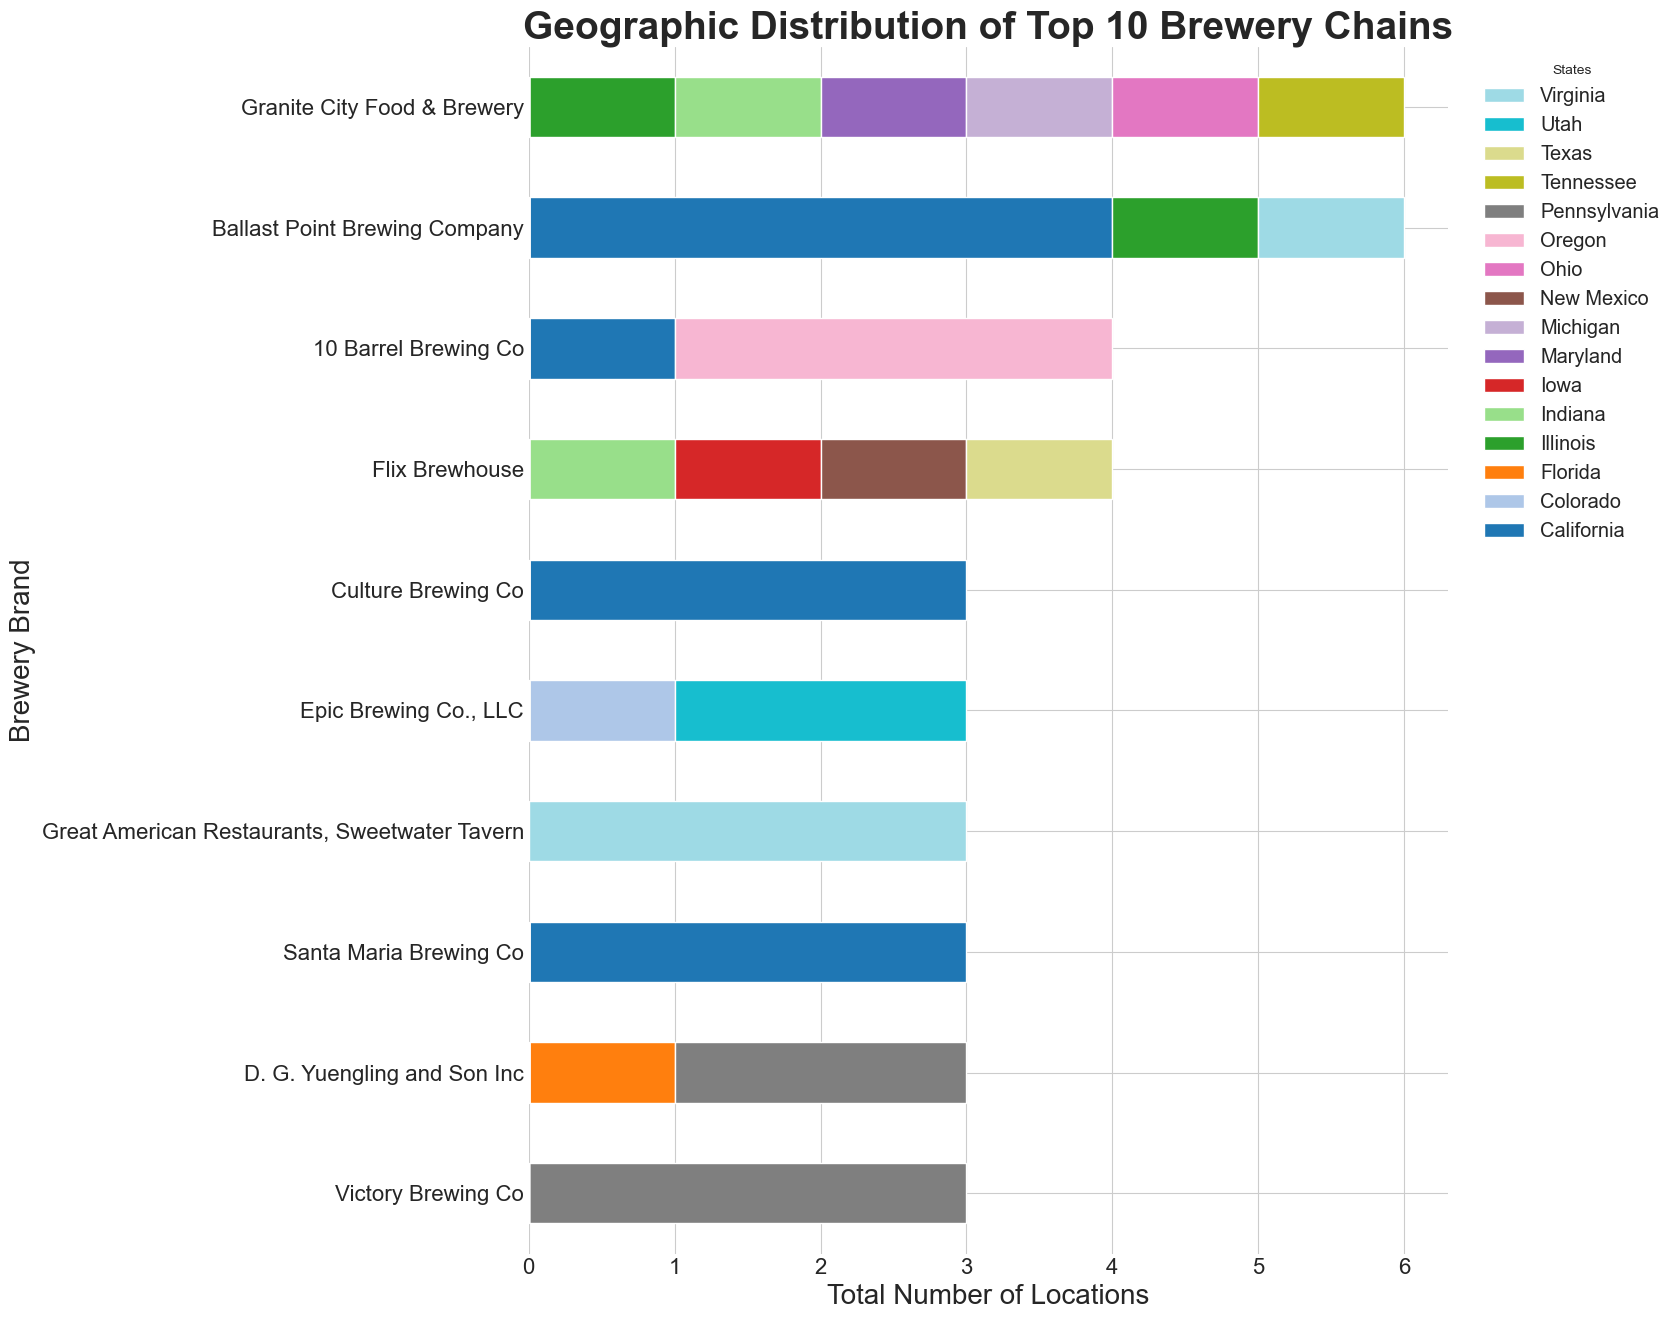

In [10]:
# 1st main
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data ---
try:
    df = pd.read_csv("done_cleaning.csv")
except FileNotFoundError:
    print("Error: 'done_cleaning.csv' not found. Please make sure the file is available.")
    exit()

# --- 2. Data Preparation for Stacked Chart ---

# Identify top 10 chains
brewery_locations = df.groupby('name').size().reset_index(name='location_count')
top_10_chains = brewery_locations.sort_values(by='location_count', ascending=False).head(10)
top_10_names = top_10_chains['name'].tolist()

# Filter the main dataframe to only include the top 10 chains
top_10_df = df[df['name'].isin(top_10_names)]

# Create a pivot table: count locations per state for each brand
location_distribution = top_10_df.groupby(['name', 'state']).size().unstack(fill_value=0)

# Sort the pivot table to match the order of the top 10 chains
location_distribution = location_distribution.loc[top_10_names]


location_distribution = location_distribution.iloc[::-1]


# --- 3. Create the Stacked Visualization ---
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20, 14))

location_distribution.plot(
    kind='barh',
    stacked=True,
    ax=ax,
    colormap='tab20'
)

# --- 4. Formatting and Titles ---

ax.set_title('Geographic Distribution of Top 10 Brewery Chains', fontsize=28, weight='bold')
ax.set_xlabel('Total Number of Locations', fontsize=20)
ax.set_ylabel('Brewery Brand', fontsize=20)

# Customize ticks
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Improve legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles), reversed(labels),
    title='States',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize='x-large'
)

plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.savefig("brewery_distribution_sorted.png")
plt.show()

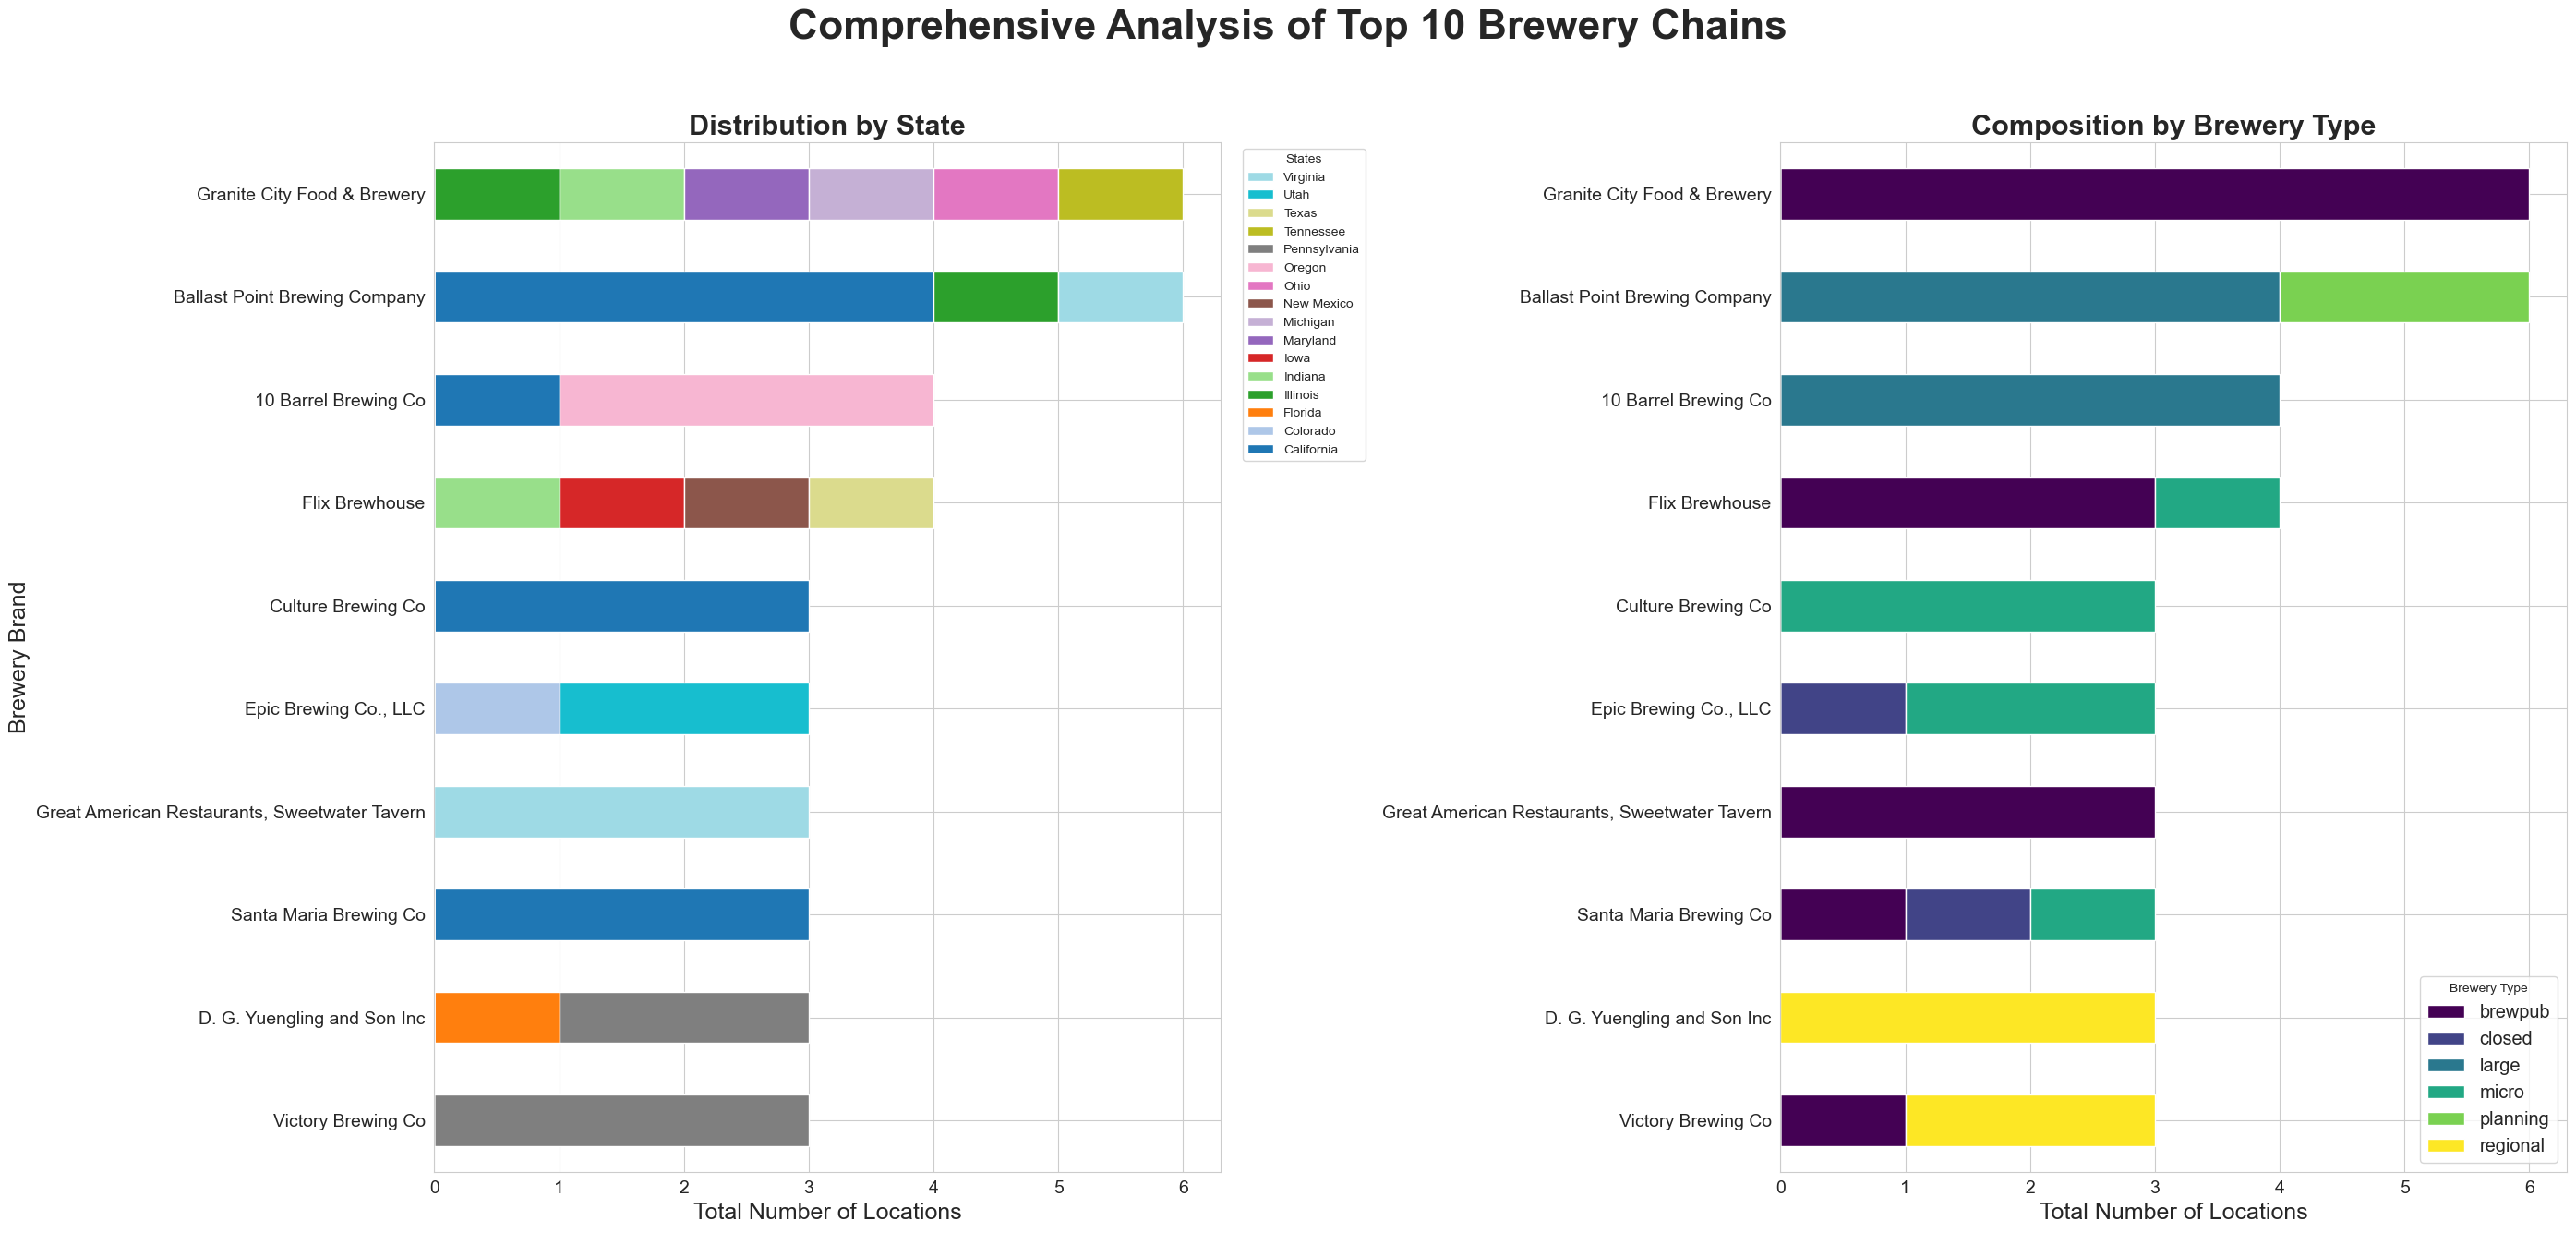

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data ---
try:
    df = pd.read_csv("done_cleaning.csv")
except FileNotFoundError:
    print("Error: 'done_cleaning.csv' not found. Please make sure the file is available.")
    exit()

# --- 2. Data Preparation ---

# Identify top 10 chains
brewery_locations = df.groupby('name').size().reset_index(name='location_count')
top_10_chains = brewery_locations.sort_values(by='location_count', ascending=False).head(10)
top_10_names = top_10_chains['name'].tolist()

# Filter for the top 10 chains
top_10_df = df[df['name'].isin(top_10_names)]

# --- Data for Plot 1: State Distribution ---
location_distribution = top_10_df.groupby(['name', 'state']).size().unstack(fill_value=0)
location_distribution = location_distribution.loc[top_10_names].iloc[::-1]

# --- Data for Plot 2: Brewery Type Distribution ---
type_distribution = top_10_df.groupby(['name', 'brewery_type']).size().unstack(fill_value=0)
type_distribution = type_distribution.loc[top_10_names].iloc[::-1]


# --- 3. Create the Combined Visualization ---
# Create a figure with two subplots side-by-side
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(28, 14))

fig.suptitle('Comprehensive Analysis of Top 10 Brewery Chains', fontsize=32, weight='bold')

# --- Plot 1: Geographic Distribution by State (Left) ---
location_distribution.plot(
    kind='barh',
    stacked=True,
    ax=axes[0],
    colormap='tab20'
)
axes[0].set_title('Distribution by State', fontsize=22, weight='bold')
axes[0].set_xlabel('Total Number of Locations', fontsize=18)
axes[0].set_ylabel('Brewery Brand', fontsize=18)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(
    reversed(handles), reversed(labels),
    title='States',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize='medium'
)

# --- Plot 2: Composition by Brewery Type (Right) ---
type_distribution.plot(
    kind='barh',
    stacked=True,
    ax=axes[1],
    colormap='viridis'
)
axes[1].set_title('Composition by Brewery Type', fontsize=22, weight='bold')
axes[1].set_xlabel('Total Number of Locations', fontsize=18)
axes[1].set_ylabel('') # Hide y-axis label to avoid repetition
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)
axes[1].legend(
    title='Brewery Type',
    loc='lower right',
    fontsize='x-large'
)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("brewery_combined_analysis.png")
plt.show()

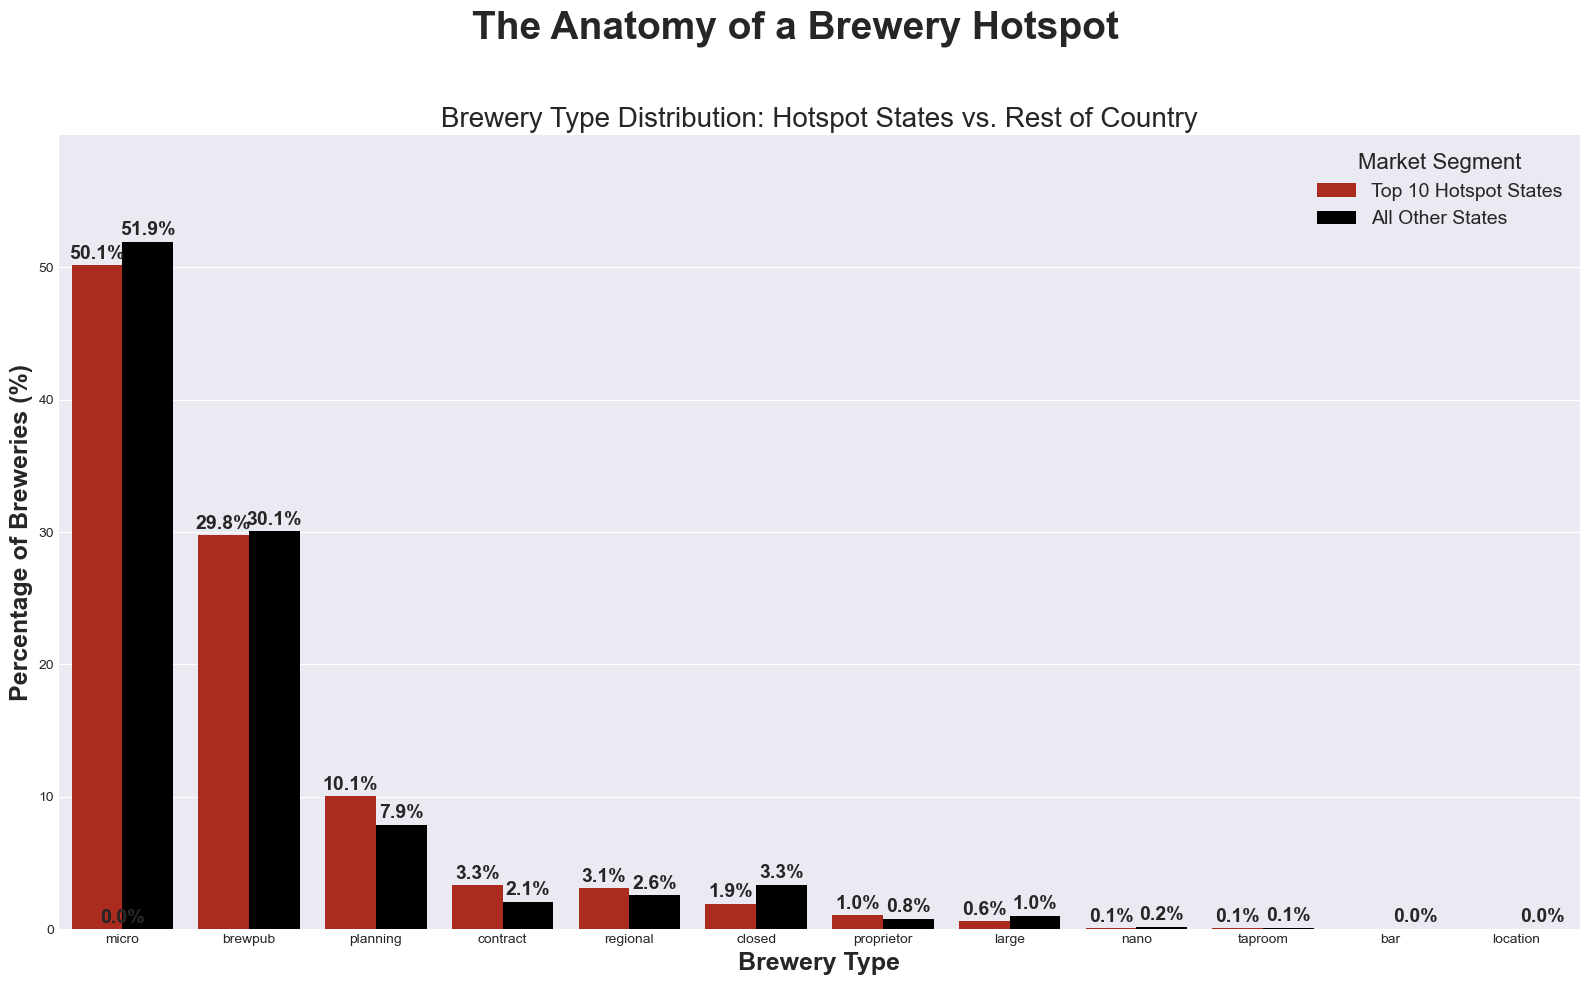

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data and Define State Areas ---
try:
    df = pd.read_csv("done_cleaning.csv")
    us_df = df[df['country'] == 'United States'].copy()
except FileNotFoundError:
    print("Error: 'done_cleaning.csv' not found. Please ensure the file is available.")
    exit()

state_areas = {
    'Alabama': 50645, 'Alaska': 570641, 'Arizona': 113594, 'Arkansas': 52035, 'California': 155779,
    'Colorado': 103642, 'Connecticut': 4842, 'Delaware': 1949, 'Florida': 53625, 'Georgia': 57513,
    'Hawaii': 6423, 'Idaho': 82643, 'Illinois': 55519, 'Indiana': 35826, 'Iowa': 55857,
    'Kansas': 81759, 'Kentucky': 39486, 'Louisiana': 43204, 'Maine': 30843, 'Maryland': 9707,
    'Massachusetts': 7800, 'Michigan': 56539, 'Minnesota': 79627, 'Mississippi': 46923,
    'Missouri': 68742, 'Montana': 145546, 'Nebraska': 76824, 'Nevada': 109781, 'New Hampshire': 8953,
    'New Jersey': 7354, 'New Mexico': 121298, 'New York': 47126, 'North Carolina': 48618,
    'North Dakota': 69001, 'Ohio': 40861, 'Oklahoma': 68595, 'Oregon': 95988, 'Pennsylvania': 44743,
    'Rhode Island': 1034, 'South Carolina': 30061, 'South Dakota': 75811, 'Tennessee': 41235,
    'Texas': 261232, 'Utah': 82170, 'Vermont': 9217, 'Virginia': 39490, 'Washington': 66456,
    'West Virginia': 24038, 'Wisconsin': 54158, 'Wyoming': 97093
}

# --- 2. Analysis ---
# Calculate brewery density to identify hotspots
state_counts = us_df['state'].value_counts().reset_index()
state_counts.columns = ['State', 'Brewery Count']
area_df = pd.DataFrame(list(state_areas.items()), columns=['State', 'Land Area (sq mi)'])
density_df = pd.merge(state_counts, area_df, on='State')
density_df['Breweries per 1k sq mi'] = (density_df['Brewery Count'] / density_df['Land Area (sq mi)']) * 1000

# Identify the Top 10 Hotspot states by density
hotspot_states = density_df.sort_values(by='Breweries per 1k sq mi', ascending=False).head(10)['State'].tolist()

# Segment the dataframe into "Hotspot" vs "Other"
hotspot_df = us_df[us_df['state'].isin(hotspot_states)]
other_states_df = us_df[~us_df['state'].isin(hotspot_states)]

# Calculate the percentage distribution of brewery types for each group
hotspot_distribution = hotspot_df['brewery_type'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
hotspot_distribution['group'] = 'Top 10 Hotspot States'

other_distribution = other_states_df['brewery_type'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
other_distribution['group'] = 'All Other States'

# Combine the data for plotting
combined_distribution = pd.concat([hotspot_distribution, other_distribution])
combined_distribution = combined_distribution.rename(columns={'brewery_type': 'Brewery Type'})


# --- 3. Visualization ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(16, 10))

# Create the grouped bar chart
sns.barplot(
    x='Brewery Type',
    y='percentage',
    hue='group',
    data=combined_distribution,
    palette={'Top 10 Hotspot States': '#C21807', 'All Other States': 'black'},
    ax=ax
)

# --- 4. Formatting and Titles ---
fig.suptitle("The Anatomy of a Brewery Hotspot", fontsize=28, weight='bold')
ax.set_title("Brewery Type Distribution: Hotspot States vs. Rest of Country", fontsize=20)
ax.set_xlabel('Brewery Type', fontsize=18, weight='bold')
ax.set_ylabel('Percentage of Breweries (%)', fontsize=18, weight='bold')

# Add percentage annotations
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2.,
        y=height + 0.5,
        s=f'{height:.1f}%',
        ha='center',
        fontsize=14,
        weight='bold'
    )

ax.set_ylim(0, ax.get_ylim()[1] * 1.1)
ax.legend(title='Market Segment', title_fontsize='16', fontsize='14')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

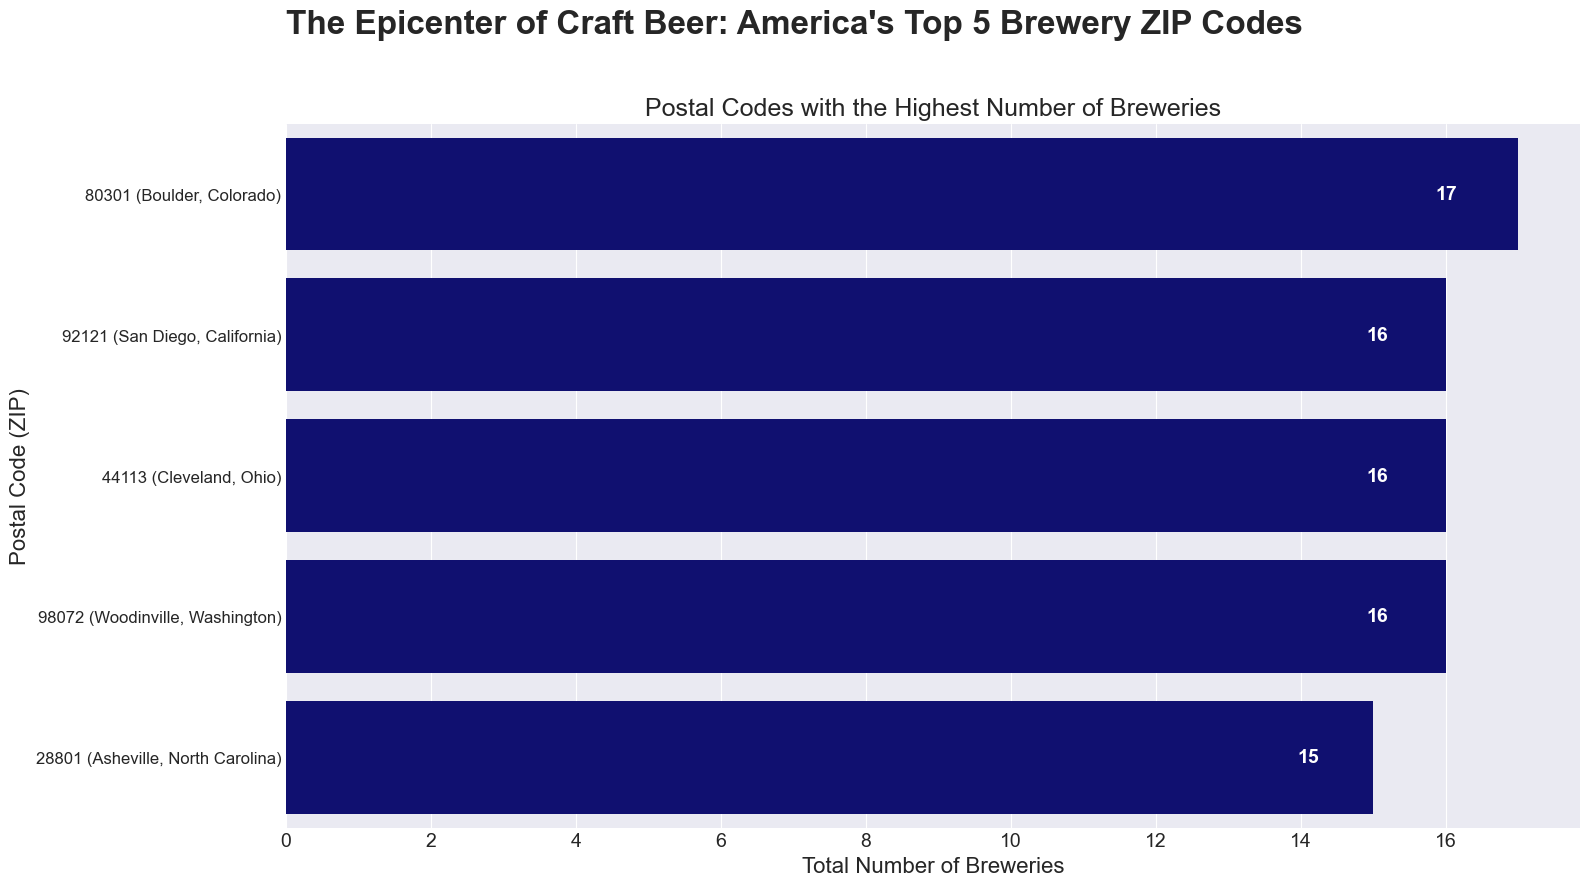

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data ---
try:
    df = pd.read_csv("done_cleaning.csv")
except FileNotFoundError:
    print("Error: 'done_cleaning.csv' not found. Please ensure the file is available.")
    exit()

# --- 2. Analysis: Find Top 5 ZIP Codes ---
# Drop missing postal codes and get the value counts
zip_counts = df.dropna(subset=['postal_code'])['postal_code'].value_counts().head(5)
top_zips_df = zip_counts.reset_index()
top_zips_df.columns = ['postal_code', 'brewery_count']

# Add City and State context for the top ZIP codes
zip_info = df[df['postal_code'].isin(top_zips_df['postal_code'])][['postal_code', 'city', 'state']].drop_duplicates()
top_zips_full_info = pd.merge(top_zips_df, zip_info, on='postal_code')

# --- FIX: Convert postal_code to string before concatenating ---
top_zips_full_info['chart_label'] = top_zips_full_info['postal_code'].astype(str) + " (" + top_zips_full_info['city'] + ", " + top_zips_full_info['state'] + ")"


# --- 3. Visualization ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(16, 9))

# Create the horizontal bar chart
sns.barplot(x='brewery_count', y='chart_label', data=top_zips_full_info, color='navy', ax=ax)


# --- 4. Formatting and Titles ---
fig.suptitle("The Epicenter of Craft Beer: America's Top 5 Brewery ZIP Codes", fontsize=24, weight='bold')
ax.set_title("Postal Codes with the Highest Number of Breweries", fontsize=18)
ax.set_xlabel('Total Number of Breweries', fontsize=16)
ax.set_ylabel('Postal Code (ZIP)', fontsize=16)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12)

# Add annotations to the bars
for p in ax.patches:
    width = p.get_width()
    ax.text(width * 0.95,
            p.get_y() + p.get_height() / 2.,
            f'{int(width)}',
            ha='right',
            va='center',
            color='white',
            weight='bold',
            fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

This analysis pinpoints the most saturated and competitive neighborhoods in the country.

The Risk: Opening a new brewery in one of these top ZIP codes means entering a "red ocean" filled with established competitors fighting for the same customers. It would be incredibly difficult for a new brand to stand out.

The Opportunity: However, these districts are also powerful magnets for craft beer tourism. A new brewery with a truly unique offering could benefit from the high volume of dedicated beer enthusiasts that are already drawn to the area.

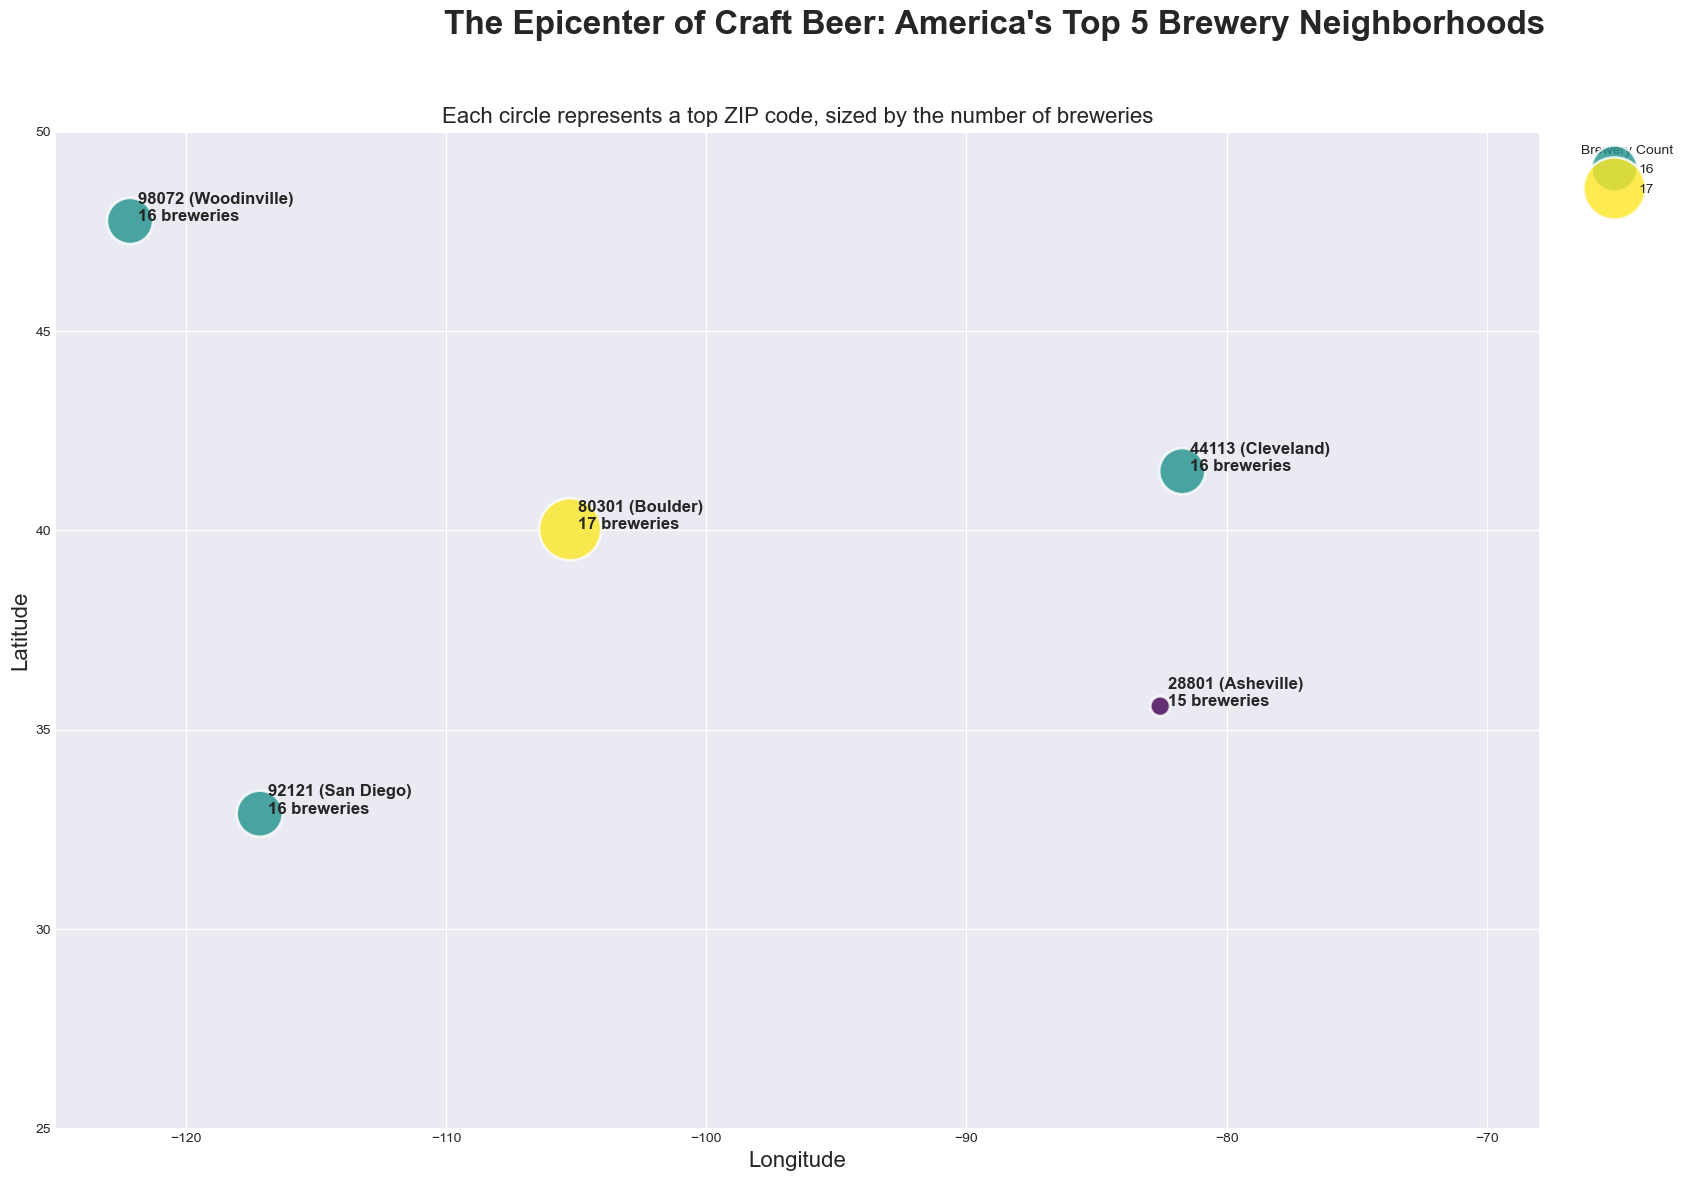

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data ---
try:
    df = pd.read_csv("done_cleaning.csv")
except FileNotFoundError:
    print("Error: 'done_cleaning.csv' not found. Please ensure the file is available.")
    exit()

# --- 2. Analysis: Find Top 5 ZIP Codes and Their Coordinates ---
# Drop missing postal codes and get the value counts
zip_counts = df.dropna(subset=['postal_code'])['postal_code'].value_counts().head(5)
top_zips_df = zip_counts.reset_index()
top_zips_df.columns = ['postal_code', 'brewery_count']

# Filter the main dataframe for just the breweries in the top ZIP codes
top_zips_locations = df[df['postal_code'].isin(top_zips_df['postal_code'])]

# Calculate the geographic center (mean lat/lon) for each top ZIP code
zip_coords = top_zips_locations.groupby('postal_code')[['latitude', 'longitude']].mean().reset_index()

# Add city/state info for context
zip_info = top_zips_locations[['postal_code', 'city', 'state']].drop_duplicates()

# Merge all information into a single dataframe for plotting
plot_df = pd.merge(top_zips_df, zip_coords, on='postal_code')
plot_df = pd.merge(plot_df, zip_info, on='postal_code')


# --- 3. Visualization ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(20, 12))

# Create the scatter plot map
# Size and color of points are determined by the number of breweries
sns.scatterplot(
    data=plot_df,
    x='longitude',
    y='latitude',
    size='brewery_count',
    hue='brewery_count',
    palette='viridis',
    sizes=(200, 2000),  # Min and max size of the circles
    alpha=0.8,
    ax=ax,
    legend='auto'
)

# --- 4. Add Annotations ---
# Add text labels to each point on the map
for i, row in plot_df.iterrows():
    ax.text(
        row['longitude'] + 0.3, # Offset text slightly from the point
        row['latitude'],
        f"{row['postal_code']} ({row['city']})\n{row['brewery_count']} breweries",
        fontsize=12,
        weight='bold',
        ha='left'
    )

# --- 5. Formatting and Titles ---
fig.suptitle("The Epicenter of Craft Beer: America's Top 5 Brewery Neighborhoods", fontsize=24, weight='bold')
ax.set_title("Each circle represents a top ZIP code, sized by the number of breweries", fontsize=16)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)

# Set plot limits to roughly frame the continental USA
ax.set_xlim(-125, -68)
ax.set_ylim(25, 50)

# Customize the legend
h, l = ax.get_legend_handles_labels()
ax.legend(h[1:6], l[1:6], title='Brewery Count', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()

In [9]:
# Add this line at the very end of the Python script
plot_df.to_csv("top_zip_code_map_data.csv", index=False)